# To determine what features will best predict cpu/event

we'll calculate averages of cpu/event per CPU and processing type and use that dummy predictor
we'll fit separately fastBmk, bogomips, hs06, whetstone to cpu/event for each processing type adn use that as a predictor

compare all 5.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


### Get datasets

In [2]:
jobs = pd.DataFrame()
input_files=['job_2017-04.csv','job_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
jobs = pd.concat(tmp)

jobs = jobs[jobs['nevents']>20]
jobs = jobs[jobs['inputsize']>1024]

jobs['cpuPerMB']= jobs['cputime']/(jobs['inputsize']/1024./1024.)
del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']
del jobs['cpuPerEvent']

jobs.head()

,hs06,processingtype,cpuPerMB
pandaid,,,
3352703758,107,recon,110.248904
3354732793,10,evgen,652.003663
3326375042,96,reprocessing,11.807224
3327803396,77,merge,1.053848
3330689156,90,merge,1.132681


In [3]:
input_files=['benchmark_2017-04.csv','benchmark_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
benchmarks = pd.concat(tmp)

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70
3322806277,5333.16,1,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,12.240734,3426.18
3322875248,5332.58,1,Intel(R) Xeon(R) CPU E5430 @ 2.66GHz,12.349914,2911.33


### join dataframes and filter out bad rows

In [4]:
benchmarks = benchmarks.join(jobs,how='inner')
# benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
# benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head()

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerMB
pandaid,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,401.351564
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,412.060215
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,425.883791
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,447.087071
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,1141.349308


### split over different processing types 

In [5]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

# UniqueProcessingTypes.remove('overlay')
UniqueProcessingTypes.remove('deriv')

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]
    

['simul' 'evgen' 'reprocessing' 'merge' 'recon' 'pmerge' 'pile' 'overlay'
 'deriv']


### plot correlations

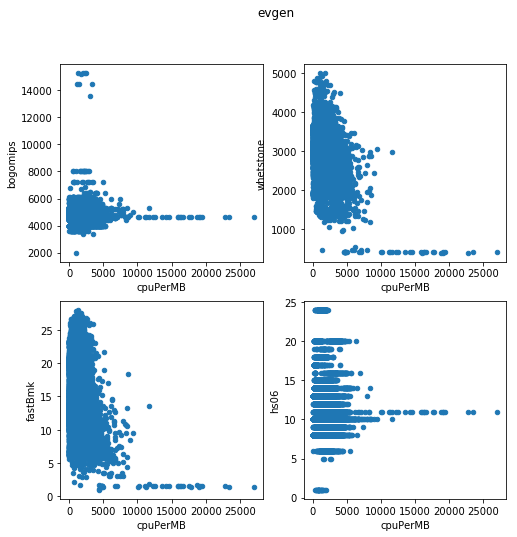

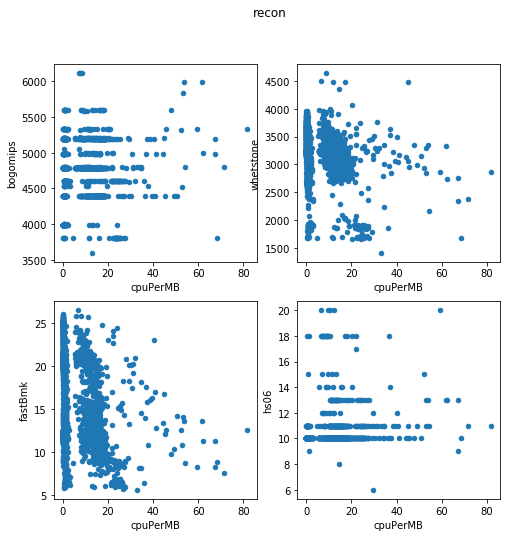

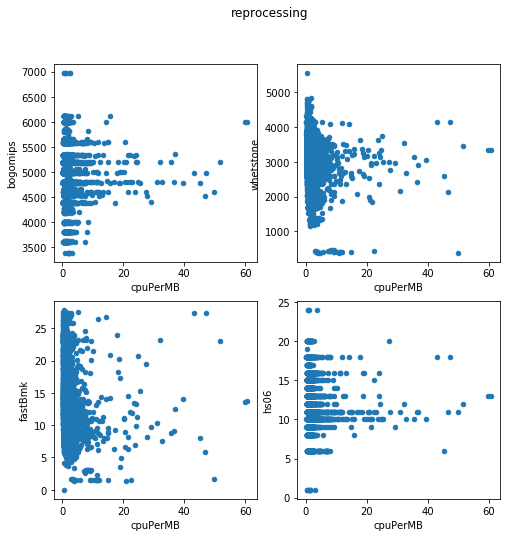

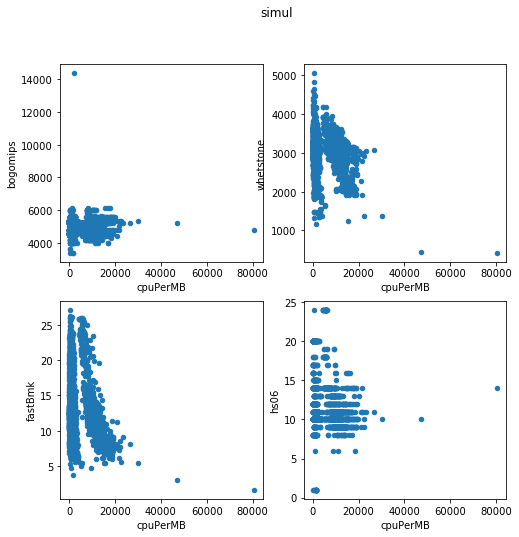

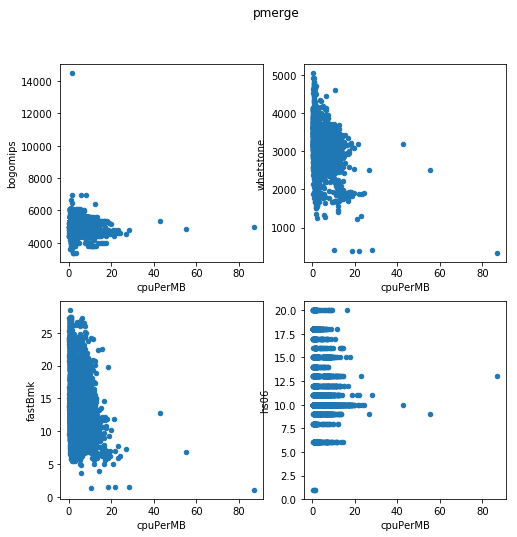

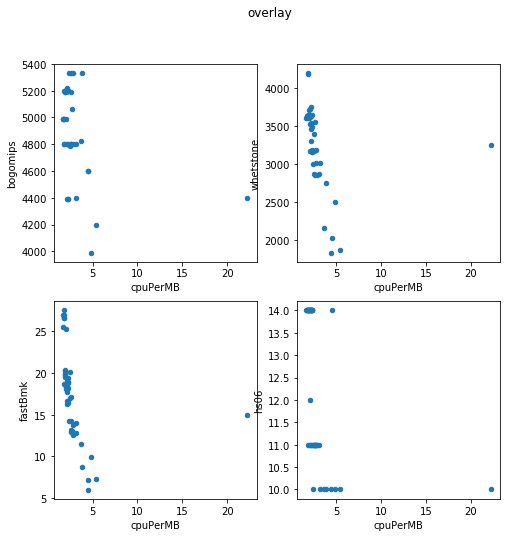

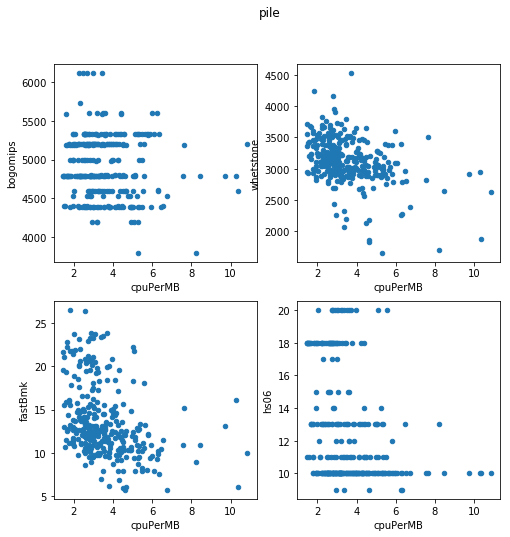

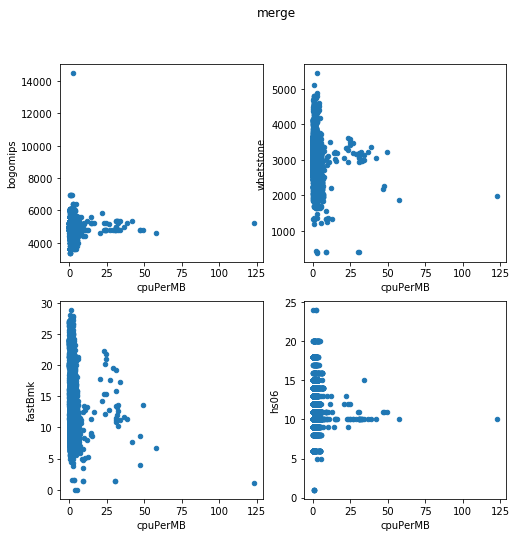

In [6]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerMB", y=f, kind='scatter',figsize=(8, 8)) 

### split on training and testing samples

===========  evgen =============
(19312, 5) (19312, 1) (4828, 5) (4828, 1)
***  bogomips  ***
cross validation score:  -1.25833912495
	evs: 0.0001 	mae:   961.3001 	mse: 1534465.6540 	r2:    0.0000
***  fastBmk  ***
cross validation score:  -1.09131901568
	evs: 0.1394 	mae:   898.8445 	mse: 1320650.9399 	r2:    0.1394
***  whetstone  ***
cross validation score:  -1.13114364752
	evs: 0.1547 	mae:   894.2776 	mse: 1297168.0457 	r2:    0.1547
***  hs06  ***
cross validation score:  -1.27568547609
	evs: 0.0115 	mae:   948.8569 	mse: 1516848.4172 	r2:    0.0115
Describe predictions
              actual     bogomips      fastBmk         hs06    whetstone
count   4828.000000  4828.000000  4828.000000  4828.000000  4828.000000
mean    1649.946464  1658.633863  1649.111251  1657.268784  1645.731454
std     1238.884601    34.394283   466.645261   108.176446   478.012836
min        0.811873   837.099875   293.661609  1224.323635   -21.339274
25%      683.670055  1640.147738  1455.393156  1605.738

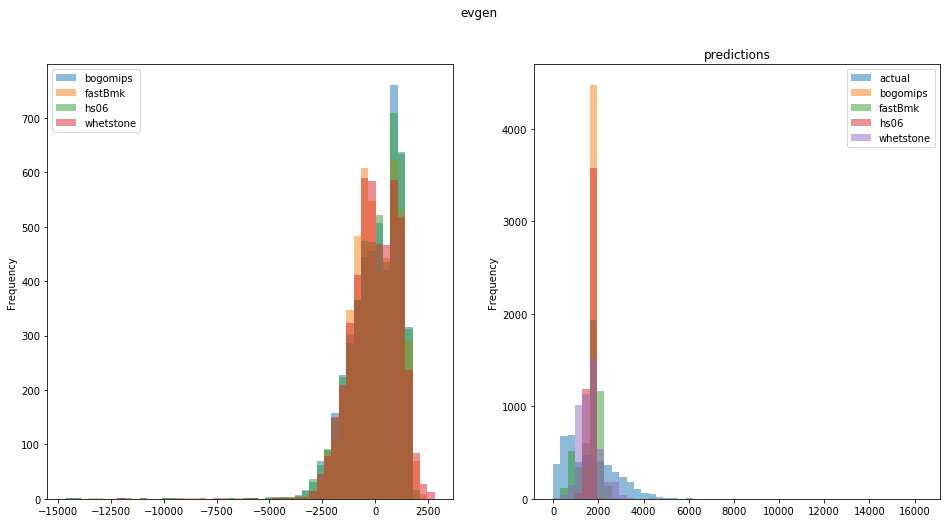

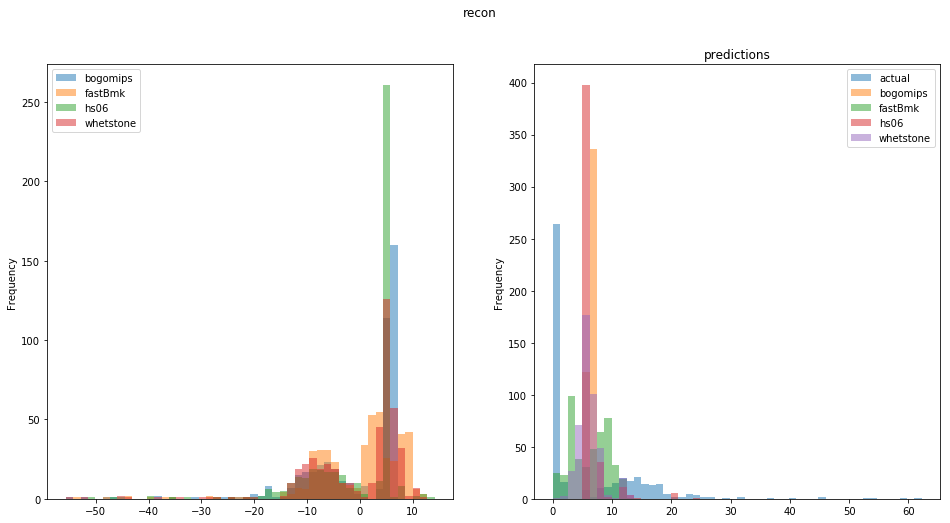

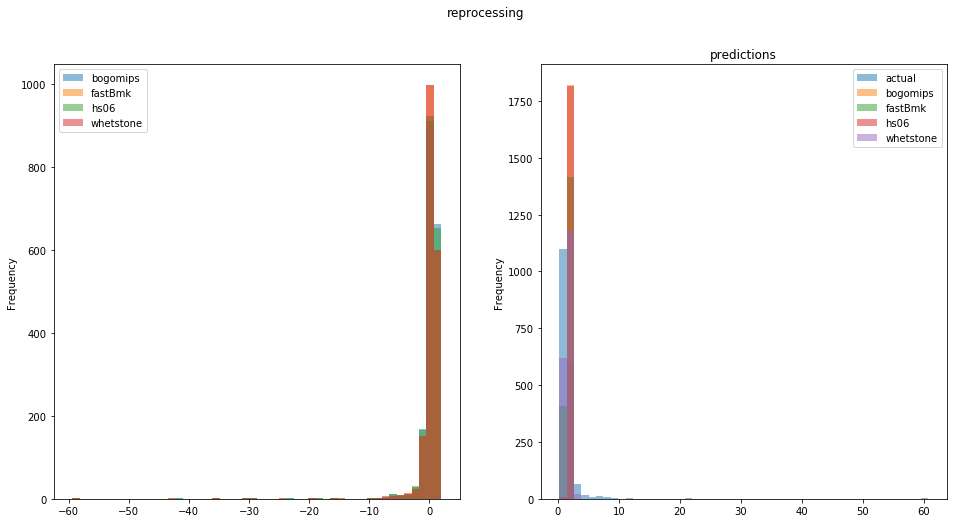

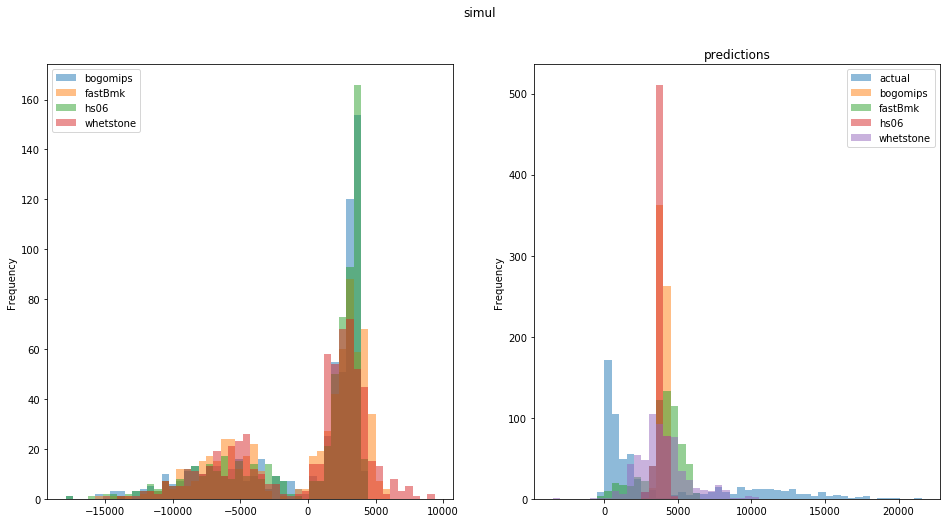

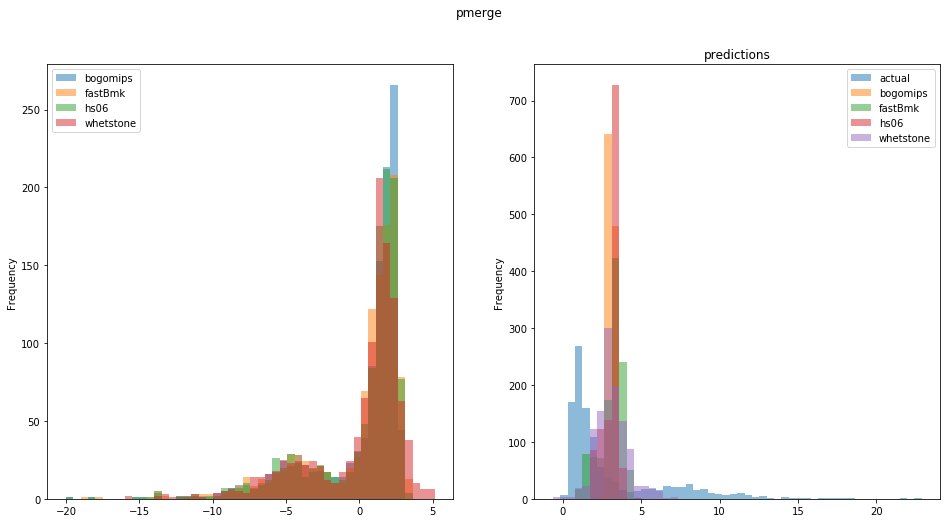

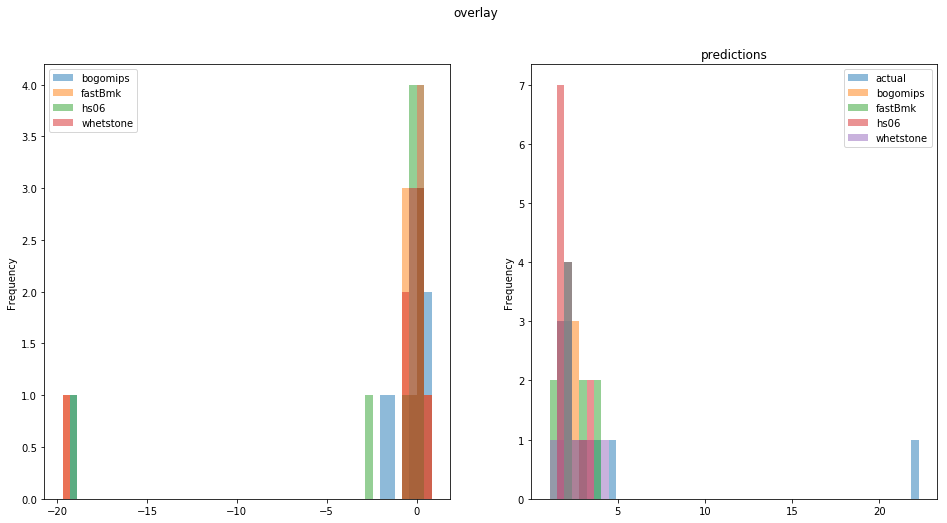

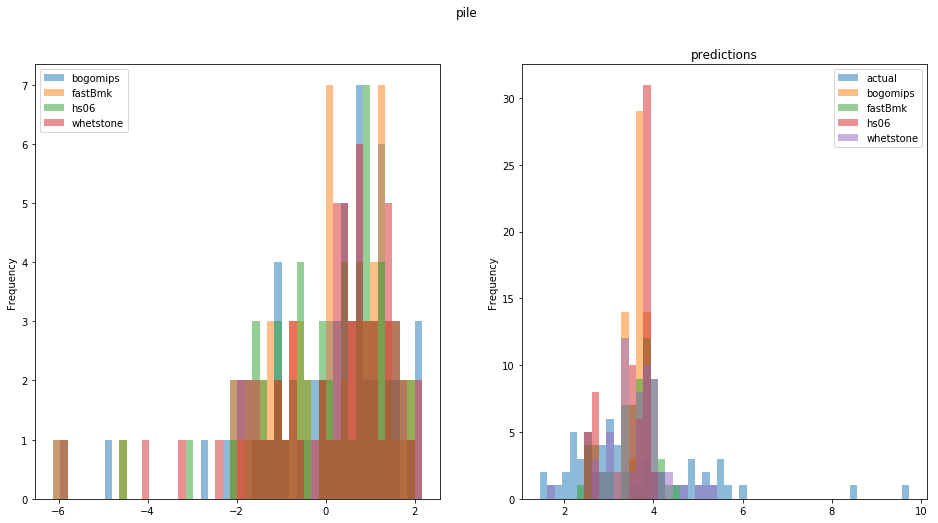

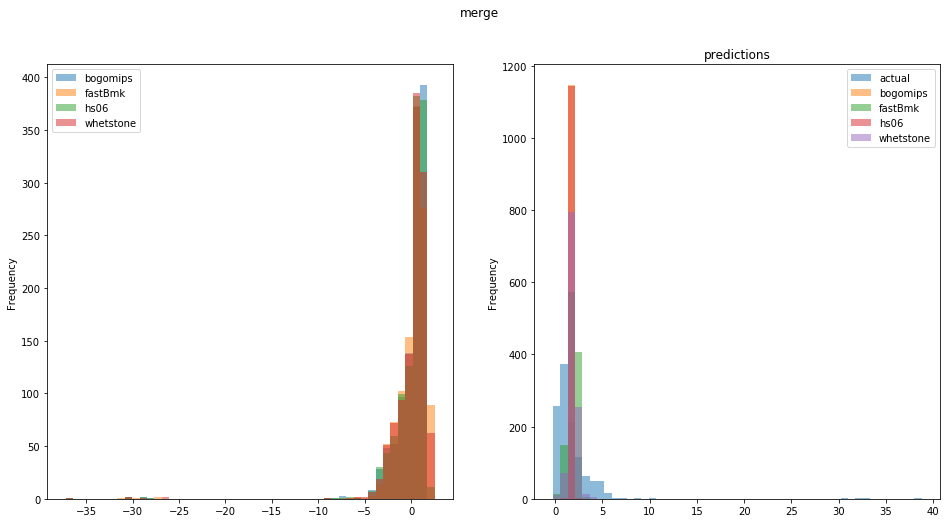

In [7]:
R_mse = {}
R_r2  = {}

#####  LRs ####
lr = LinearRegression()

for pt in ProcessingType:
    print("=========== ",pt,"=============")
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerMB'].copy()
    y = y.values.reshape(-1, 1)
    #print(data['cpuPerEvent'].describe())
    
    X=data.copy()
    del X['cpuPerMB']
    del X['processingtype']
    #print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
        
        lm = lr.fit(X_train[f].values.reshape(-1,1), y_train)
        #print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[f].values.reshape(-1,1))
        
        # to do cross validation 
        scores = cross_val_score(lr, X[f].values.reshape(-1,1), y, cv=10, scoring='r2')
        print("cross validation score: ", scores.mean())
        #y_test_predict = cross_val_predict(lr, X, y, cv=10)
        
        
        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()
        
        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        #print("---------------------------------------")
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.suptitle(pt)
    plt.title("errors")
    pl = pd.DataFrame(errors)
    #print("Describe residuals\n", pl.describe())
    pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    
    pl = pd.DataFrame(predictions)
    plt.title("predictions")
    print("Describe predictions\n", pl.describe())
    pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
        
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']

    cdata_train, cdata_test =  train_test_split( cdata, test_size=0.20, random_state=41)
    print(cdata_train.shape, cdata_test.shape)

    predictions_on_CPU = cdata_train.groupby('cpuname').mean()
    #print(predictions_on_CPU)

    res=[]
    pre=[]
    not_used=0
    for index, row in cdata_test.iterrows():
        cn  = row['cpuname']
        cpe = row['cpuPerMB']
        if cn in predictions_on_CPU.index:
            res.append(cpe)
            pre.append(predictions_on_CPU.loc[cn,'cpuPerMB'])
        else:
            not_used += 1 

    #print(not_used,' test results had CPU not seen in training data.')
        
    #for i in range(len(res)):
    #    print(res[i], pre[i])
    comp=pd.DataFrame({'res':res,'pre':pre})
    #comp

    evs = explained_variance_score(comp.res, comp.pre)
    mae = mean_absolute_error(comp.res, comp.pre)
    mse = mean_squared_error(comp.res, comp.pre)
    r2 = r2_score(comp.res, comp.pre) 
    #print( "%2.4f" % evs, "{:>10.4f}".format(mae), "{:>10.4f}".format(mse), "{:>10.4f}".format(r2)) 
    tmse.append(mae)
    tr2.append(r2)
    R_mse[pt]=tmse
    R_r2[pt]=tr2
    print("---------------------------------------")
        
#print(R_r2)

### plot results

In [8]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,overlay,pile,pmerge,recon,reprocessing,simul
bogomips,0.000034,-0.000529,-0.025264,-0.005452,0.004674,0.001005,-0.000387,0.001016
fastBmk,0.139370,0.029697,-0.057923,0.097565,0.045787,0.124183,0.000019,0.061257
whetstone,0.154673,0.044053,-0.089888,0.030535,0.066248,0.038730,0.009879,0.071210
hs06,0.011514,0.000250,-0.029310,0.054169,0.010978,0.103681,-0.000429,-0.002098
cpu name,0.158680,-0.022258,-0.097123,0.103764,0.073950,0.397760,-0.001150,0.298730


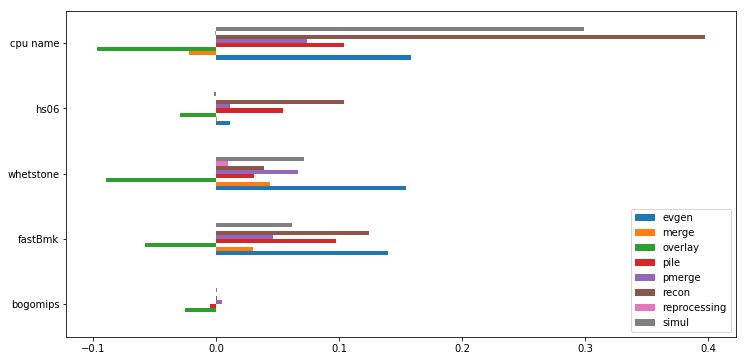

In [9]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")

In [10]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,overlay,pile,pmerge,recon,reprocessing,simul
bogomips,961.300086,1.287835,2.456724,1.156625,2.577252,7.324689,0.937667,4159.698043
fastBmk,898.844508,1.276383,2.282203,1.099215,2.516120,6.522487,0.917179,4180.486330
whetstone,894.277593,1.276830,2.238823,1.181405,2.508790,7.196134,0.907185,4095.667262
hs06,948.856852,1.296605,2.309322,1.160078,2.562440,7.025868,0.937235,4207.502643
cpu name,867.754622,1.272449,2.306971,1.068923,2.489630,4.719966,0.938171,3048.148658


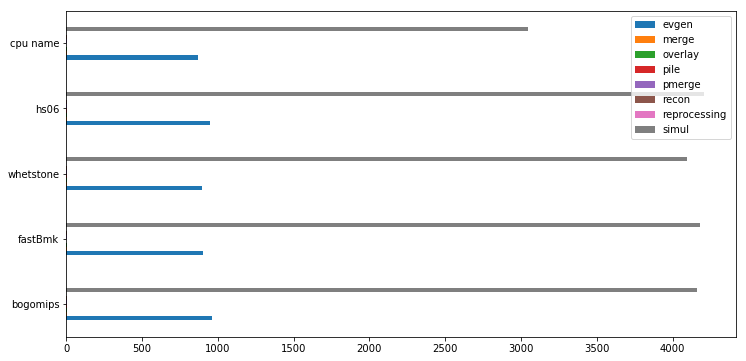

In [11]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks.png")